In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import sys
from IPython.display import Image
from shapely.geometry import Point, Polygon
from math import factorial
import datetime
import time
import scipy

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression
from patsy import cr

from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
import sys
# search path for modules
# look @ https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/remote_sensing/python/')
import remote_sensing_core as remote_core

# Plan for rough estimate:
   1. perennials, and grasses and non irrigated (Why google slide doess not say annuals)
    

# Function definitions

# Directories

In [3]:
data_dir = "/Users/hn/Documents/01_research_data/Ag_check_point/remote_sensing/01_NDVI_TS/Grant/"

# Data Reading

In [4]:
file_names = ["Grant_2018_TS.csv"]
file_N = file_names[0]

In [5]:
a_df = pd.read_csv(data_dir + file_N)
a_df = remote_core.initial_clean(a_df)
a_df.head(2)

,Acres,B2,B3,B4,B8,CovrCrp,CropGrp,CropTyp,DataSrc,ExctAcr,...,NDVI,Notes,RtCrpTy,Shap_Ar,Shp_Lng,TRS,county,doy,year,geo
0,30,0.743039,0.708845,0.805611,0.728629,NaN,Cereal Grain,Wheat,NASS,30.356486,...,-0.051402,Winter Wheat,Wheat Fallow,122848.340543,2265.483255,T23R26E2,Grant,2.0,2018.0,"{""type"":""Polygon"",""coordinates"":[[[-119.527755..."
1,30,0.600203,0.556632,0.638710,0.617168,NaN,Cereal Grain,Wheat,NASS,30.356486,...,-0.015851,Winter Wheat,Wheat Fallow,122848.340543,2265.483255,T23R26E2,Grant,29.0,2018.0,"{""type"":""Polygon"",""coordinates"":[[[-119.527755..."


In [6]:
# Count distict values, use nunique:
pprint (a_df['geo'].nunique())

# Count only non-null values, use count:
print (a_df['geo'].count())

# Count total values including null values, use size attribute:
print (a_df['geo'].size)

7
378
378


# Iterate through polygons and count peaks

In [7]:
peak_dt = remote_core.generate_peak_df(a_df)

In [10]:
polygon_list = a_df['geo'].unique()
for a_poly in polygon_list:
    curr_field = a_df[a_df['geo']==a_poly]
    plot_TS(an_EE_TS_df, xp_axis='doy', yp_axis='NDVI')

(378, 23)

In [42]:
year = int(an_EE_TS_df['year'].unique())
plant = an_EE_TS_df['CropTyp'].unique()[0]
county = an_EE_TS_df['county'].unique()[0]

In [29]:
curr_field.columns

Index(['Acres', 'B2', 'B3', 'B4', 'B8', 'CovrCrp', 'CropGrp', 'CropTyp',
       'DataSrc', 'ExctAcr', 'IntlSrD', 'Irrigtn', 'LstSrvD', 'NDVI', 'Notes',
       'RtCrpTy', 'Shap_Ar', 'Shp_Lng', 'TRS', 'county', 'doy', 'year', 'geo'],
      dtype='object')

In [30]:
an_EE_TS_df['county'].unique()[0]

In [32]:
xp_axis='doy'
yp_axis='NDVI'

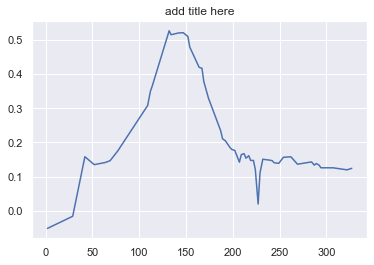

In [40]:
sb.set();

TS_plot = plt.plot(an_EE_TS_df[xp_axis], an_EE_TS_df[yp_axis]);

In [50]:
an_EE_TS_df.head(5)

,Acres,B2,B3,B4,B8,CovrCrp,CropGrp,CropTyp,DataSrc,ExctAcr,...,NDVI,Notes,RtCrpTy,Shap_Ar,Shp_Lng,TRS,county,doy,year,geo
0,30,0.743039,0.708845,0.805611,0.728629,NaN,Cereal Grain,Wheat,NASS,30.356486,...,-0.051402,Winter Wheat,Wheat Fallow,122848.340543,2265.483255,T23R26E2,Grant,2.0,2018.0,"{""type"":""Polygon"",""coordinates"":[[[-119.527755..."
1,30,0.600203,0.556632,0.638710,0.617168,NaN,Cereal Grain,Wheat,NASS,30.356486,...,-0.015851,Winter Wheat,Wheat Fallow,122848.340543,2265.483255,T23R26E2,Grant,29.0,2018.0,"{""type"":""Polygon"",""coordinates"":[[[-119.527755..."
2,30,0.122759,0.112220,0.126724,0.175051,NaN,Cereal Grain,Wheat,NASS,30.356486,...,0.158425,Winter Wheat,Wheat Fallow,122848.340543,2265.483255,T23R26E2,Grant,42.0,2018.0,"{""type"":""Polygon"",""coordinates"":[[[-119.527755..."
3,30,0.130238,0.119416,0.138850,0.182457,NaN,Cereal Grain,Wheat,NASS,30.356486,...,0.135200,Winter Wheat,Wheat Fallow,122848.340543,2265.483255,T23R26E2,Grant,52.0,2018.0,"{""type"":""Polygon"",""coordinates"":[[[-119.527755..."
4,30,0.111967,0.091533,0.097551,0.129902,NaN,Cereal Grain,Wheat,NASS,30.356486,...,0.141652,Winter Wheat,Wheat Fallow,122848.340543,2265.483255,T23R26E2,Grant,64.0,2018.0,"{""type"":""Polygon"",""coordinates"":[[[-119.527755..."


In [53]:
plot_title = county + ", " + plant + ", " + str(year) + ", (" + TRS + ")"

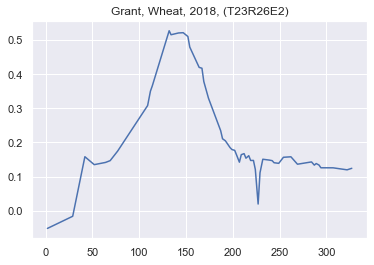